In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
csv_path = "/kaggle/input/face-recognition-dataset/Dataset.csv"
faces_dir = "/kaggle/input/face-recognition-dataset/Faces/Faces"

df = pd.read_csv(csv_path)

In [ ]:
# Tạo tập test: lấy 5 ảnh mỗi nhãn
test_indices = []
train_indices = []
label_counts = defaultdict(int)

for idx, row in df.iterrows():
    label = row['label']
    if label_counts[label] < 5:
        test_indices.append(idx)
        label_counts[label] += 1
    else:
        train_indices.append(idx)

df_train = df.iloc[train_indices].reset_index(drop=True)
df_test = df.iloc[test_indices].reset_index(drop=True)

In [ ]:
#  Mã hóa nhãn
all_labels = sorted(df['label'].unique())
label2idx = {label: idx for idx, label in enumerate(all_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}

df_train['label_idx'] = df_train['label'].map(label2idx)
df_test['label_idx'] = df_test['label'].map(label2idx)

In [ ]:
# Dataset và transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class FaceDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id'])
        image = Image.open(img_path).convert('RGB')
        label = row['label_idx']
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# DataLoader
train_dataset = FaceDataset(df_train, faces_dir, transform)
test_dataset = FaceDataset(df_test, faces_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# ResNet model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(label2idx))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


In [ ]:
# Loss và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Huấn luyện (50 epoch demo)
for epoch in range(50):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 145.4995
Epoch 2: Loss = 22.4379
Epoch 3: Loss = 5.5074
Epoch 4: Loss = 1.8454
Epoch 5: Loss = 0.8489
Epoch 6: Loss = 1.5007
Epoch 7: Loss = 0.9947
Epoch 8: Loss = 0.6824
Epoch 9: Loss = 0.6773
Epoch 10: Loss = 3.0850
Epoch 11: Loss = 5.5484
Epoch 12: Loss = 4.3727
Epoch 13: Loss = 3.5334
Epoch 14: Loss = 2.4772
Epoch 15: Loss = 2.4667
Epoch 16: Loss = 0.5555
Epoch 17: Loss = 0.5933
Epoch 18: Loss = 0.6480
Epoch 19: Loss = 0.2475
Epoch 20: Loss = 0.1151
Epoch 21: Loss = 0.1525
Epoch 22: Loss = 0.1109
Epoch 23: Loss = 0.1280
Epoch 24: Loss = 0.3139
Epoch 25: Loss = 5.1527
Epoch 26: Loss = 5.9991
Epoch 27: Loss = 2.9322
Epoch 28: Loss = 2.0834
Epoch 29: Loss = 0.8064
Epoch 30: Loss = 0.3690
Epoch 31: Loss = 0.4383
Epoch 32: Loss = 0.3856
Epoch 33: Loss = 0.7318
Epoch 34: Loss = 0.3397
Epoch 35: Loss = 0.9846
Epoch 36: Loss = 0.2266
Epoch 37: Loss = 0.1493
Epoch 38: Loss = 0.1015
Epoch 39: Loss = 0.1647
Epoch 40: Loss = 0.7109
Epoch 41: Loss = 0.8204
Epoch 42: Loss = 2.820

In [ ]:
# Đánh giá trên tập test
model.eval()
correct = 0
total = 0
all_preds = []
all_labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().tolist())
        all_labels_list.extend(labels.cpu().tolist())

print(f"\n Accuracy on test set (5 ảnh mỗi nhãn): {correct}/{total} = {100 * correct / total:.2f}%")


🎯 Accuracy on test set (5 ảnh mỗi nhãn): 152/155 = 98.06%


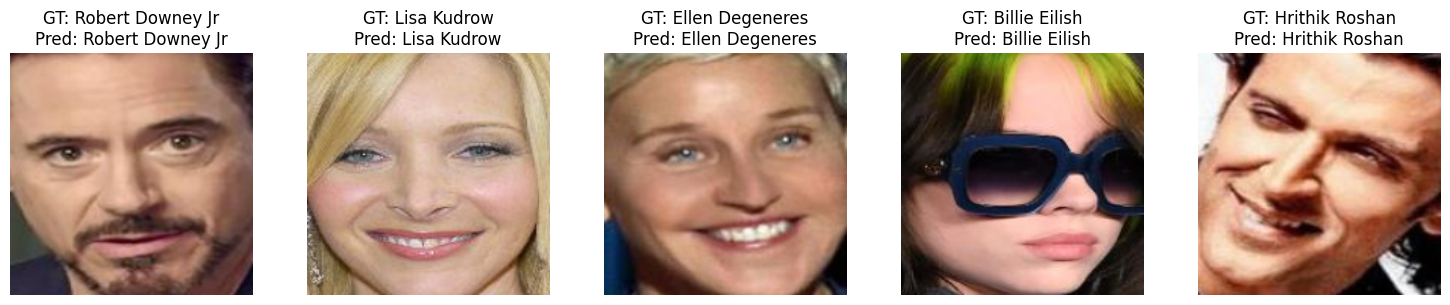

In [ ]:
# Hiển thị một vài ảnh từ test set với dự đoán
test_images, test_labels = next(iter(DataLoader(test_dataset, batch_size=5)))
test_images = test_images.to(device)

with torch.no_grad():
    test_outputs = model(test_images)
    test_preds = torch.argmax(test_outputs, dim=1)

# plot
plt.figure(figsize=(15, 3))
for i in range(5):
    img = test_images[i].cpu().permute(1, 2, 0).numpy()
    gt = idx2label[test_labels[i].item()]
    pd = idx2label[test_preds[i].item()]
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"GT: {gt}\nPred: {pd}")
    plt.axis("off")
plt.tight_layout()
plt.show()